# Brain Explorer

## Initialization

In [9]:
from IPython.display import display, HTML

data_dir = './output/hippo_exp/analyzed'

%matplotlib inline

display(HTML('''
<style>
       .jupyter-widgets-output-area .output_scroll {
            height: unset !important;
            border-radius: unset !important;
            -webkit-box-shadow: unset !important;
            box-shadow: unset !important;
        }
        .jupyter-widgets-output-area  {
            height: auto !important;
        }
</style>
<script>
function code_toggle() {
 if ($("#toggle_button").val() == "Hide code"){
     $('div.input').hide();
     $("#toggle_button").val("Show code")
 } else {
     $('div.input').show();
     $("#toggle_button").val("Hide code")
 }
}

$(document).ready(code_toggle);
</script>
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
<form action="javascript:code_toggle()">
    <input type="submit" id="toggle_button" value="Hide code">
</form>
'''
))

## Aggregate Brain Data

In [10]:
from explorer.ui import BrainAggregatesHistogramPlot, ResultsSelector, RawDataResultsSelector
from IPython.display import display, HTML, Javascript, Markdown
import ipywidgets as widgets
from explorer.explorer_utils import hist
import pickle


plot_pane = widgets.Output()
new_hist_button = widgets.Button(description='New histogram')
new_hist_button.on_click(lambda b:
                         plot_pane.append_display_data(
                             BrainAggregatesHistogramPlot(data_dir,
                                                          ResultsSelector(pickle.load(open(f'{data_dir}/../stats.pickle', 'rb'))))))
new_plot_button = widgets.Button(description='New raw data histogram', layout=widgets.Layout(width='auto'))
new_plot_button.on_click(lambda b:
                         plot_pane.append_display_data(
                             BrainAggregatesHistogramPlot(data_dir, RawDataResultsSelector(data_dir))))
clear_button = widgets.Button(description='Clear')
clear_button.on_click(lambda b: plot_pane.clear_output())

display(widgets.HBox((new_hist_button, new_plot_button, clear_button)))
display(plot_pane)

Output()

BrainAggregatesHistogramPlot(children=(Output(), DataSelector(children=(ExperimentsSelector(children=(HBox(chi…

BrainAggregatesHistogramPlot(children=(Output(), DataSelector(children=(ExperimentsSelector(children=(HBox(chi…

## Statistic Tests

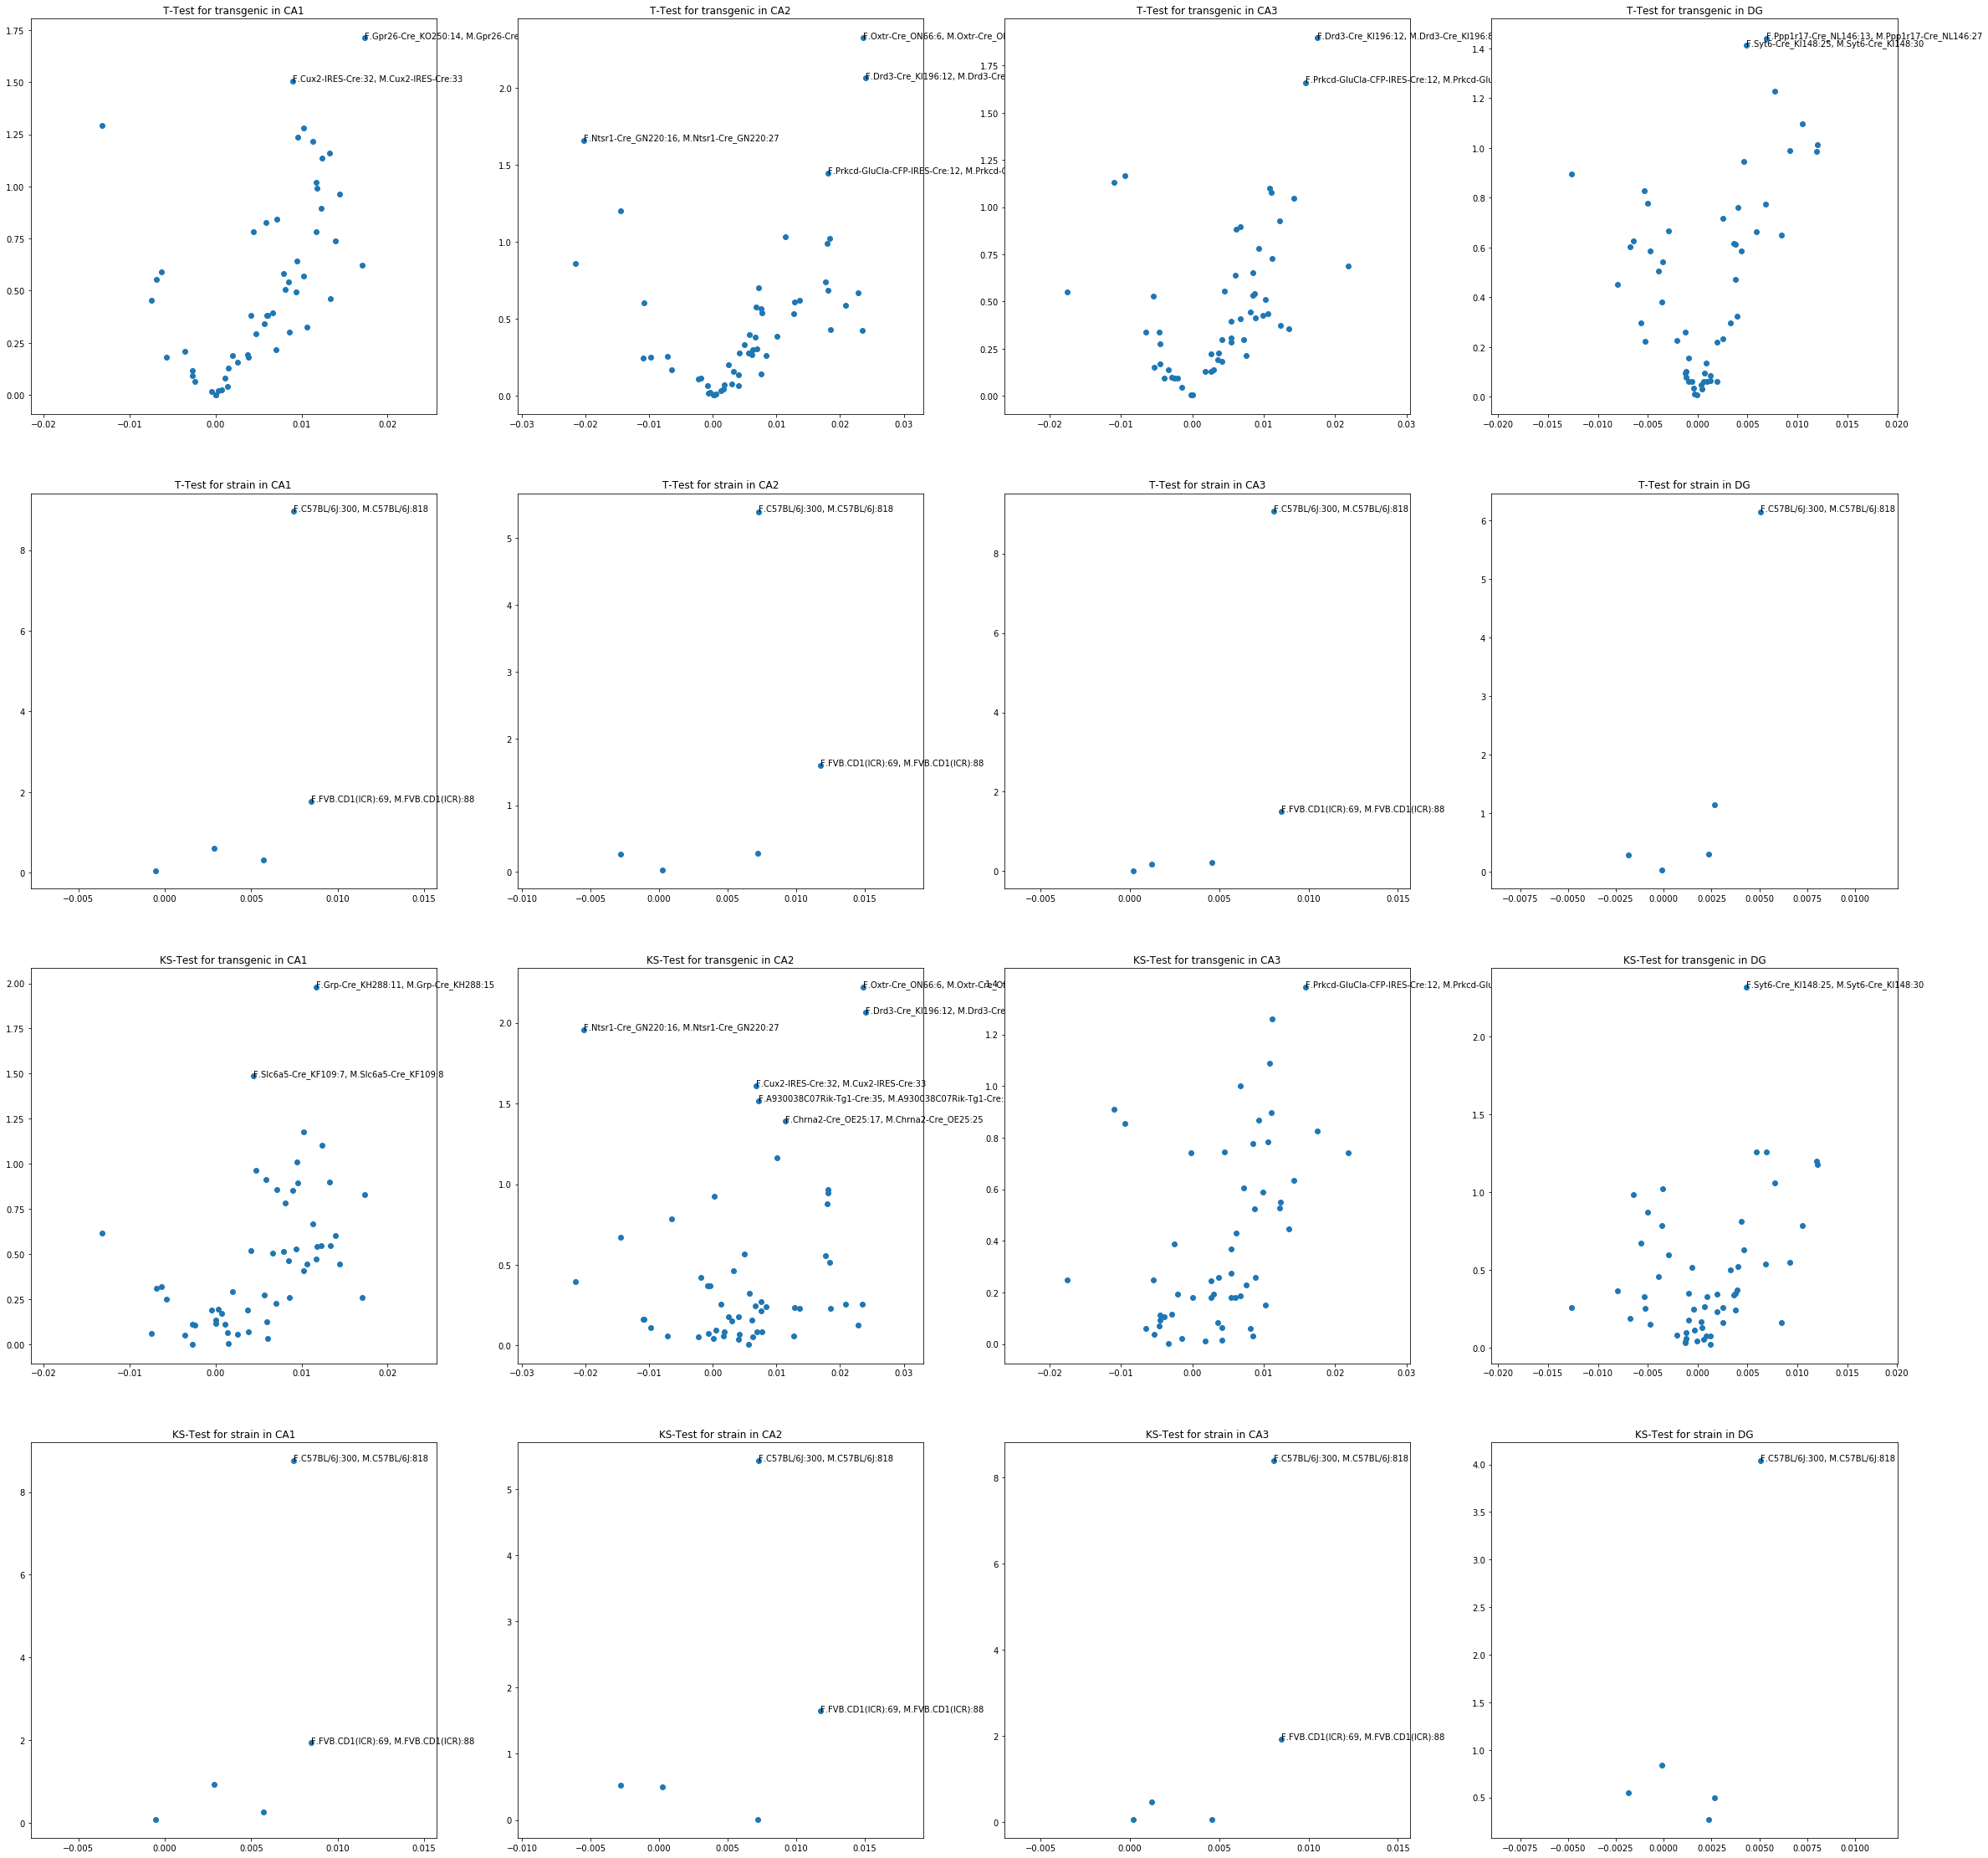

In [28]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

import math
import pickle

import scipy.stats as stats
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

def filter_cols(df, columns):
    for n, v in columns:
        df = df[df[n] == v]
    return df

def infinite_dict():
    return defaultdict(infinite_dict)


def ids_to_data(region, attribute, df, columns, data):
    ids = filter_cols(df, columns).id.to_numpy().tolist()
    return np.array([data[str(e)]['dense'][region][attribute]['mean'] for e in ids])

experiments = mcc.get_experiments(dataframe=True)
experiments = experiments[experiments.id.isin([int(e) for e in results.keys()])]

genders = experiments.gender.unique().tolist()
transgenic_lines = experiments.transgenic_line.unique().tolist()
strains = experiments.strain.unique().tolist()
regions = ['CA1', 'CA2', 'CA3', 'DG']

tests = {'T-Test': stats.ttest_ind, 'KS-Test': stats.kstest}

def perform_pairwise_comparisons(regions, name_pairs, experiments, data, tests):
    test_results = infinite_dict()

    for l, r in name_pairs:
        for region in regions:
            l_data = ids_to_data(region, 'density', experiments, l, data)
            r_data = ids_to_data(region, 'density', experiments, r, data)
            if len(l_data) > 3 and len(r_data) > 3:
                for test_name, test in tests.items():
                    pvalue = test(l_data, r_data).pvalue
                    test_results[test_name][region][f"{'.'.join(list(zip(*l))[1])}:{len(l_data)}," \
                                                    f" {'.'.join(list(zip(*r))[1])}:{len(r_data)}"] = (
                        -math.log10(pvalue), l_data.mean() - r_data.mean())

    return test_results

test_results = dict()
test_results_whole_population = perform_pairwise_comparisons(regions, [((('gender', 'F'),), (('gender', 'M'),))],
                                                             experiments, results, tests)

name_pairs = [tuple([(('gender', g), ('transgenic_line', t)) for g in genders]) for t in transgenic_lines]
name_pairs = list({tuple(sorted(list(p))) for p in name_pairs})

test_results['transgenic'] = perform_pairwise_comparisons(regions, name_pairs, experiments, results, tests)

name_pairs = [tuple([(('gender', g), ('strain', t)) for g in genders]) for t in experiments.strain.unique().tolist()]
name_pairs = list({tuple(sorted(list(p))) for p in name_pairs})

test_results['strain'] = perform_pairwise_comparisons(regions, name_pairs, experiments, results, tests)

fig, ax = plt.subplots(len(tests) * len(test_results), len(regions), figsize=(40, 40))

for res_num, (tr_name, tr) in enumerate(test_results.items()):
    for test_num, test in enumerate(tr.keys()):
        row = test_num * len(test_results) + res_num
        for col, (region, points) in enumerate(tr[test].items()):
            x = np.array([v[1] for v in points.values()])
            y = np.array([v[0] for v in points.values()])
            ax[row, col].scatter(x, y, label=tr_name)
            for i, label in enumerate(points.keys()):
                if y[i] > 1.3:
                    ax[row, col].annotate(label, (x[i], y[i]))
            ax[row, col].set_title(f'{test} for {tr_name} in {region}')
plt.show()

## Brain details

In [5]:
import pandas as pd
import os
import random
import numpy as np
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
import pickle

import ipywidgets as widgets
from explorer.ui import ExperimentsSelector, SectionHistogramPlotter
from IPython.display import display

%matplotlib inline

bins = 50
mcc = MouseConnectivityCache(manifest_file=f'mouse_connectivity/mouse_connectivity_manifest.json',
                             resolution=25)
input_dir = 'output/hippo_exp/analyzed'

def on_select_experiment(*args):
    experiment_id = experiment_combo.value
    if not experiment_id:
        section_combo.options = []
        section_combo.value = None
        section_combo.disabled = True
    else:
        if experiment_id == 'random':
            experiment_id = random.choice(experiment_combo.options)
        experiment_combo.value = experiment_id
        directory = f"{input_dir}/{experiment_id}"
        with open(f'{directory}/bboxes.pickle', "rb") as f:
            bboxes = pickle.load(f)
        bboxes = {k: v for k, v in bboxes.items() if v}
        section_combo.options = ['all', 'totals'] + list(str(i) for i in bboxes.keys())
        section_combo.value = section_combo.options[0]
        section_combo.disabled = False

experiments_selector = ExperimentsSelector()
histograms_output = widgets.Output()

def refresh(b):
    experiments_selector.set_available_brains(set([int(e) for e in os.listdir(input_dir) if e.isdigit()]))
    experiment_ids = set(experiments_selector.get_selection())
    if experiment_ids:
        experiment_combo.options = ['random'] + sorted([str(e) for e in experiment_ids])
        experiment_combo.value = ''
        experiment_combo.disabled = False
    else:
        experiment_combo.options = []
        experiment_combo.value = ''
        experiment_combo.disabled = True

def display_experiment(b):
    experiment_id = experiment_combo.value
    section = section_combo.value
    if not experiment_id or not section:
        return
    
    directory = f"{input_dir}/{experiment_id}"
    full_data = pd.read_parquet(f"{directory}/celldata-{experiment_id}.parquet")
    full_data_mtime = os.path.getmtime(f"{directory}/celldata-{experiment_id}.csv")
    with histograms_output:
        if section == 'all':
            SectionHistogramPlotter(experiment_id, 'totals', full_data, full_data_mtime, input_dir,
                                    mcc.get_structure_tree())
            for section in sorted(full_data.section.unique().tolist()):
                section_data = full_data[full_data.section==int(section)]
                SectionHistogramPlotter(experiment_id, section, section_data, full_data_mtime, input_dir,
                                        mcc.get_structure_tree())
        else:
            if section != 'totals':
                full_data = full_data[full_data.section==int(section)]
            SectionHistogramPlotter(experiment_id, section, full_data, full_data_mtime, input_dir,
                                    mcc.get_structure_tree())

# plot = SectionHistogramPlotter('brain', full_data)
experiment_combo = widgets.Combobox(options=['random'],
                         value='random',
                         ensure_option=True,
                         description='Choose experiment: ')

section_combo = widgets.Dropdown(options=['50'],
                         value=None,
                         description='Choose section:')

experiment_combo.observe(on_select_experiment, 'value')

refresh_button = widgets.Button(description='Refresh experiment list')
refresh_button.layout.width = 'auto'
refresh_button.on_click(refresh)

display_button = widgets.Button(description='Go!')
display_button.on_click(display_experiment)

clear_button = widgets.Button(description='Clear plots')
clear_button.on_click(lambda b: histograms_output.clear_output())

experiments_selector.on_selection_change(lambda col, change: refresh(refresh_button))

display(widgets.HBox((experiments_selector, refresh_button)))
display(widgets.HBox((experiment_combo, section_combo, display_button, clear_button)))
display(histograms_output)
refresh(refresh_button)
on_select_experiment()


Output()

In [68]:
garbage=[302221478, 304543821]